In [1]:
import gaia_roman_combined as grc

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

import astropy
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u

#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

import os

plotpath = './figures/'
if not os.path.isdir(plotpath):
    os.makedirs(plotpath)


In [2]:
'''
This simulation is following the definition of the HLWAS Medium fields defined here:
https://roman-docs.stsci.edu/roman-community-defined-surveys/high-latitude-wide-area-survey#HighLatitudeWideAreaSurvey-Medium-Tier-Summary
'''

'\nThis simulation is following the definition of the HLWAS Medium fields defined here:\nhttps://roman-docs.stsci.edu/roman-community-defined-surveys/high-latitude-wide-area-survey#HighLatitudeWideAreaSurvey-Medium-Tier-Summary\n'

In [3]:
#define some default values

roman_pos_floor_err = 0.01*grc.roman_pix_scale #mas, floor or pos uncertainty, (standard is 1% pixel)
gaia_era = 'DR5' #choose from ['DR3','DR4','DR5']

roman_background = 'hlwas-medium_field1'
roman_background_level = 'medium'

#example with 100 magnitudes
n_stars = 100
gaia_mags = np.linspace(15,30,n_stars)

#get expected astrometry for all Gaia Data Releases (for comparison)

gaia_drs = ['DR3','DR4','DR5']
gaia_precision_dict = {}
for dr in gaia_drs: 
    gaia_precisions = grc.gaia_astrometry_precision(gaia_mags,era=dr)
    gaia_dracosdec_errs = gaia_precisions[0]
    gaia_ddec_errs = gaia_precisions[1]
    gaia_pmra_errs = gaia_precisions[2]
    gaia_pmdec_errs = gaia_precisions[3]
    gaia_parallax_errs = gaia_precisions[4]
    #geometric-mean uncertainty for position and PM
    gaia_precision_dict[dr] = {
        'gaia_pos_errs':np.sqrt(gaia_dracosdec_errs*gaia_ddec_errs),
        'gaia_pm_errs':np.sqrt(gaia_pmra_errs*gaia_pmdec_errs),
        'gaia_parallax_errs':gaia_parallax_errs,
    }


In [4]:
print(f'Currently Using a Roman position uncertainty floor of {roman_pos_floor_err} mas')

print()

print('Allowed Roman filters are:',grc.allowed_filters)

print()
print('Allowed Roman background choices are:\n',grc.allowed_backgrounds)
print()
print('Allowed Roman background level choices are:',grc.allowed_background_levels)

print()
print('Allowed Roman MultiAccum choices are:')
print('#MA_Name            Exposure Time (seconds)')
for ma_name in grc.allowed_ma_names:
    print(f'{ma_name:20s}{round(grc.ma_integration_times[ma_name],1)}')


Currently Using a Roman position uncertainty floor of 1.078577405 mas

Allowed Roman filters are: ['F062', 'F087', 'F106', 'F129', 'F146', 'F158', 'F184', 'F213']

Allowed Roman background choices are:
 ['hltds', 'gbtds_mid_5stripe', 'hlwas-medium_field1', 'hlwas-medium_field2', 'hlwas-wide_field1', 'hlwas-wide_field2', 'hlwas-wide_field3', 'hlwas-wide_field4']

Allowed Roman background level choices are: ['medium']

Allowed Roman MultiAccum choices are:
#MA_Name            Exposure Time (seconds)
IM_60_6_S           60
IM_66_6             66
IM_76_7_S           76
IM_85_7             85
IM_95_7             95
IM_101_7            101
IM_107_7            107
IM_107_8_S          107
IM_120_8            120
IM_135_8            135
IM_152_9            152
IM_171_10           171
IM_193_11           193
IM_193_14_S         193
IM_225_13           225
IM_250_14           250
IM_284_14           284
IM_294_16           294
IM_307_16           307
IM_360_16           360
IM_409_16           40

/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 10000 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


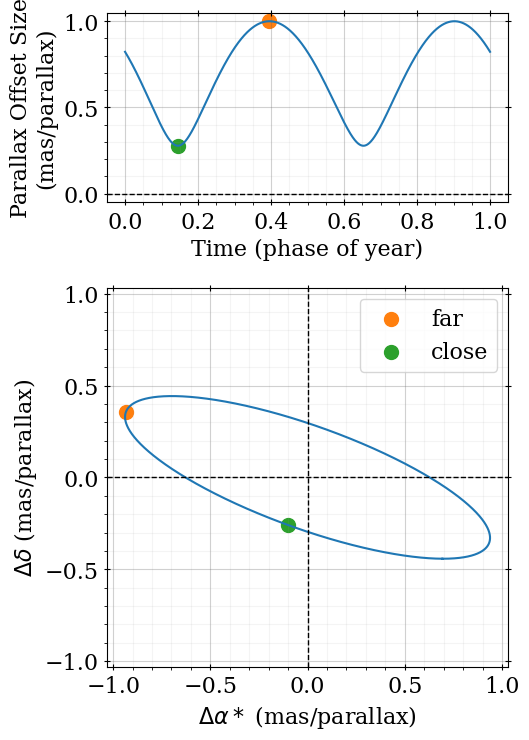

Far time is J2027.3956395639564
Close time is J2027.144914491449


In [5]:
'''
Use RA,Dec to determine best times of year for observations to constrain parallax
(i.e. maximum of the parallax ellipse)
'''

ra,dec = 45,-25 #medium field 2
ra,dec = 150,-5 #medium field 1

times = Time(np.linspace(2027,2028,10000),format='jyear')
test_parallax_vectors = grc.delta_ra_dec_per_parallax_VECTORIZED(times,Time(2016.0,format='jyear'),ra,dec)

parallax_distances = np.sqrt(np.sum(np.power(test_parallax_vectors,2),axis=1))
time_ind = np.where(parallax_distances == parallax_distances[times.jyear < 2027.5].max())[0][0]
best_time = times[time_ind]
best_ind_plus_half = np.argmin(np.abs((best_time-times).to(u.year).value+0.5))
close_ind = np.where(parallax_distances == parallax_distances[times.jyear < 2027.5].min())[0][0]
close_time = times[close_ind]
close_ind_plus_half = np.argmin(np.abs((close_time-times).to(u.year).value+0.5))

plt.figure(figsize=np.array(np.array((5,7))*1.1))
gs = gridspec.GridSpec(2,1,hspace=0.3,height_ratios=[1,2],left=0.22,right=0.95,top=0.95,bottom=0.1)

ax = plt.subplot(gs[0])    
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

plt.plot(times.jyear-times.jyear.min(),parallax_distances)
plt.scatter(times.jyear[time_ind]-times.jyear.min(),parallax_distances[time_ind],
            label='far_para = J%.2f'%(best_time.jyear),c='C1',s=100)
# plt.scatter(times.jyear[best_ind_plus_half],
#             parallax_distances[best_ind_plus_half],c='C1',s=100,marker='s',alpha=0.5)
plt.scatter(times.jyear[close_ind]-times.jyear.min(),parallax_distances[close_ind],
            label='close_para = J%.2f'%(close_time.jyear),c='C2',s=100)
# plt.scatter(times.jyear[close_ind_plus_half],
#             parallax_distances[close_ind_plus_half],c='C2',s=100,marker='s',alpha=0.5)
plt.xlabel('Time (phase of year)')
plt.ylabel('Parallax Offset Size\n(mas/parallax)')
plt.axhline(0,c='k',lw=1,ls='--')
# plt.show()

ax = plt.subplot(gs[1])    
# ax.set_aspect('equal')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(test_parallax_vectors[:,0],test_parallax_vectors[:,1])
plt.scatter(test_parallax_vectors[time_ind,0],test_parallax_vectors[time_ind,1],
            label='far',c='C1',s=100)
# plt.scatter(test_parallax_vectors[best_ind_plus_half,0],
#             test_parallax_vectors[best_ind_plus_half,1],c='C1',s=100,marker='s',alpha=0.5)
plt.scatter(test_parallax_vectors[close_ind,0],test_parallax_vectors[close_ind,1],
            label='close',c='C2',s=100)
# plt.scatter(test_parallax_vectors[close_ind_plus_half,0],
#             test_parallax_vectors[close_ind_plus_half,1],c='C2',s=100,marker='s',alpha=0.5)
plt.xlabel(r'$\Delta\alpha*$ (mas/parallax)')
plt.ylabel(r'$\Delta\delta$ (mas/parallax)')
# plt.legend(loc='best')
plt.legend(loc=1)
plt.axhline(0,c='k',lw=1,ls='--')
plt.axvline(0,c='k',lw=1,ls='--')
ylim = np.array(plt.ylim())
xlim = np.array(plt.xlim())
xwidth = np.diff(xlim)[0]
ywidth = np.diff(ylim)[0]
xmid = 0.5*xwidth+xlim[0]
ymid = 0.5*ywidth+ylim[0]
width = max(xwidth,ywidth)
xlim = width*np.array([-0.5,0.5])+xmid
ylim = width*np.array([-0.5,0.5])+ymid
plt.ylim(ylim)
plt.xlim(xlim)
# plt.ylim(ylim[0],ylim[1]*1.75)
plt.savefig(f'{plotpath}HLWAS_Medium_field_1_parallax_offsets.png')
plt.show()


print(f'Far time is J{best_time.jyear}')
print(f'Close time is J{close_time.jyear}')


In [6]:
medium_times = best_time + np.array([0,0.5,2.5,3,3.5,4])*u.year
medium_times = best_time + np.array([0,0.5,3,3.5,4,4.5])*u.year
medium_filters = ['F106','F129','F158','F158','F129','F106']
medium_dithers = np.ones(len(medium_filters))*3
medium_MAs = ['IM_107_7']*len(medium_filters)

wide_times = close_time + np.array([0,4])*u.year
wide_times = close_time + np.array([0,4.5])*u.year
wide_filters = ['F158']*len(wide_times)
wide_dithers = np.ones(len(wide_filters))*3
wide_MAs = ['IM_107_7']*len(wide_filters)


roman_filters = np.unique(medium_filters)

#example with 100 magnitudes
n_stars = 100

#assuming color of stars in all filters is 0 and zeropoint with Gaia is also 0
roman_mags = np.zeros((n_stars,len(roman_filters))) 
roman_mags[:] = np.linspace(16,27,n_stars)[:,None]         #AB mags
gaia_mags = roman_mags[:,0]

medium_observation_list = list(zip(medium_times.mjd,medium_filters,medium_dithers,medium_MAs))
medium_precision = grc.gaia_roman_astrometric_precision(
    roman_mags = roman_mags,
    roman_filters = roman_filters,
    gaia_mags = gaia_mags,
    roman_pos_floor_err = roman_pos_floor_err,
    observation_list = medium_observation_list,
    gaia_era = gaia_era,
    ra = ra, dec = dec,
    roman_background = roman_background,
    roman_background_level = roman_background_level
)

wide_observation_list = list(zip(wide_times.mjd,wide_filters,wide_dithers,wide_MAs))
wide_precision = grc.gaia_roman_astrometric_precision(
    roman_mags = roman_mags,
    roman_filters = roman_filters,
    gaia_mags = gaia_mags,
    roman_pos_floor_err = roman_pos_floor_err,
    observation_list = wide_observation_list,
    gaia_era = gaia_era,
    ra = ra, dec = dec,
    roman_background = roman_background,
    roman_background_level = roman_background_level
)


/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 6 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 6 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 2 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_5288/2908176161.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


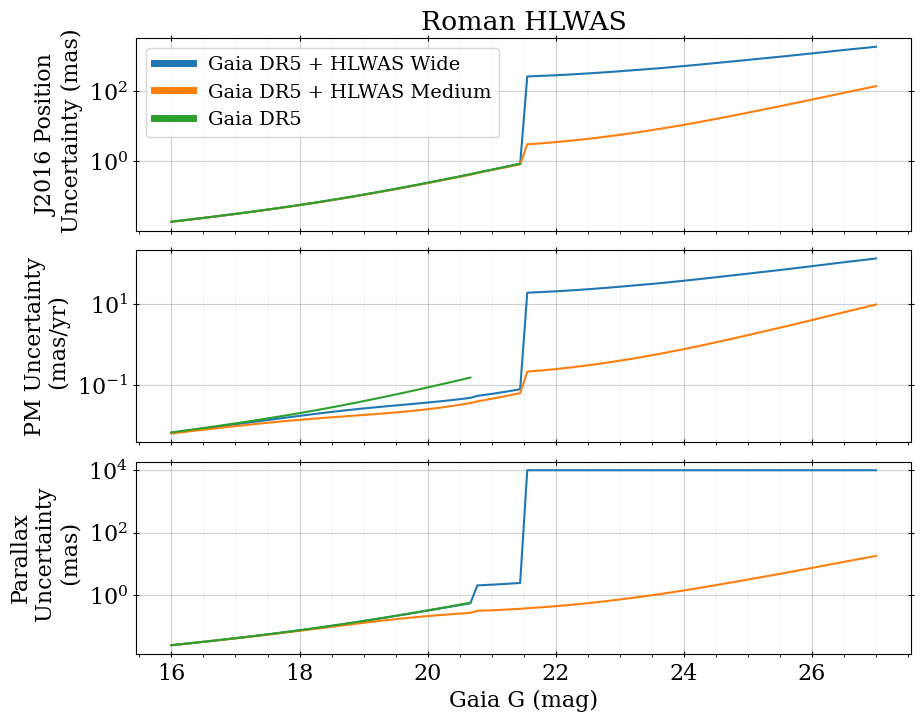

In [7]:
log_scale = True
# log_scale = False


plt.figure(figsize=(10,8))

gs = gridspec.GridSpec(3,1,hspace=0.1)
ax = plt.subplot(gs[0])    
plt.title('Roman HLWAS')
if log_scale:
    ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(wide_precision.gaia_gs,wide_precision.final_pos_errs,label=f'Gaia {wide_precision.gaia_era} + HLWAS Wide')
plt.plot(medium_precision.gaia_gs,medium_precision.final_pos_errs,label=f'Gaia {medium_precision.gaia_era} + HLWAS Medium')
plt.plot(wide_precision.gaia_gs,wide_precision.gaia_pos_errs,label=f'Gaia {wide_precision.gaia_era}',zorder=10)
# plt.xlabel('Gaia G (mag)')
plt.ylabel('J2016 Position\n Uncertainty (mas)')
if not log_scale:
    ylim = plt.ylim()
    plt.ylim(0,min(ylim[1],10.5))
xlim = plt.xlim()
leg = plt.legend(loc='best',fontsize=14)
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])

ax = plt.subplot(gs[1])    
if log_scale:
    ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(wide_precision.gaia_gs,wide_precision.final_pm_errs,label=f'Gaia {wide_precision.gaia_era} + HLWAS Wide')
plt.plot(medium_precision.gaia_gs,medium_precision.final_pm_errs,label=f'Gaia {medium_precision.gaia_era} + HLWAS Medium')
plt.plot(wide_precision.gaia_gs,wide_precision.gaia_pm_errs,label=f'Gaia {wide_precision.gaia_era}',zorder=10)
# plt.xlabel('Gaia G (mag)')
if not log_scale:
    ylim = plt.ylim()
    plt.ylim(0,min(ylim[1],2.3))
plt.xlim(xlim)
plt.ylabel('PM Uncertainty\n (mas/yr)')
ax.set_xticklabels([])

ax = plt.subplot(gs[2])    
if log_scale:
    ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(wide_precision.gaia_gs,wide_precision.final_parallax_errs,label=f'Gaia {wide_precision.gaia_era} + HLWAS Wide')
plt.plot(medium_precision.gaia_gs,medium_precision.final_parallax_errs,label=f'Gaia {medium_precision.gaia_era} + HLWAS Medium')
plt.plot(wide_precision.gaia_gs,wide_precision.gaia_parallax_errs,label=f'Gaia {wide_precision.gaia_era}',zorder=10)
if not log_scale:
    ylim = plt.ylim()
    plt.ylim(0,min(ylim[1],5))
plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Uncertainty\n (mas)')
plt.tight_layout()
plt.show()


In [19]:
med_time_options = {
    # 'good_para':best_time + np.array([0,0.5,3,3.5,4,4.5])*u.year,
    # 'bad_para':close_time + np.array([0,0.5,3,3.5,4,4.5])*u.year,
    # 'no_para':close_time + np.array([0,0,0,5,5,5])*u.year,
    # 'early':close_time + np.array([0,0,0,0.5,0.5,0.5])*u.year,
    'no_para':best_time + np.array([0,0,0,5,5,5])*u.year,
    'early (far)':best_time + np.array([0,0,0,0.5,0.5,0.5])*u.year,
    'early (close)':close_time + np.array([0,0,0,0.5,0.5,0.5])*u.year,
    'late (far)':best_time + np.array([0,0.5,3,3.5,4,4.5])*u.year,
    'late (close)':close_time + np.array([0,0.5,3,3.5,4,4.5])*u.year,
                   }

#example with 100 magnitudes
n_stars = 100

medium_filters = ['F106','F129','F158','F158','F129','F106']
medium_dithers = np.ones(len(medium_filters))*3
medium_MAs = ['IM_107_7']*len(medium_filters)

#assuming color of stars in all filters is 0 and zeropoint with Gaia is also 0
roman_filters = np.unique(medium_filters)
roman_mags = np.zeros((n_stars,len(roman_filters))) 
roman_mags[:] = np.linspace(15,30,n_stars)[:,None]         #AB mags
gaia_mags = roman_mags[:,0]

precision_dict = {}
for key in med_time_options:
    medium_times = med_time_options[key]
    
    medium_observation_list = list(zip(medium_times.mjd,medium_filters,medium_dithers,medium_MAs))
    precision_dict[key] = grc.gaia_roman_astrometric_precision(
        roman_mags = roman_mags,
        roman_filters = roman_filters,
        gaia_mags = gaia_mags,
        roman_pos_floor_err = roman_pos_floor_err,
        observation_list = medium_observation_list,
        gaia_era = gaia_era,
        ra = ra, dec = dec,
        roman_background = roman_background,
        roman_background_level = roman_background_level
    )


/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 6 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 6 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 6 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 6 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function

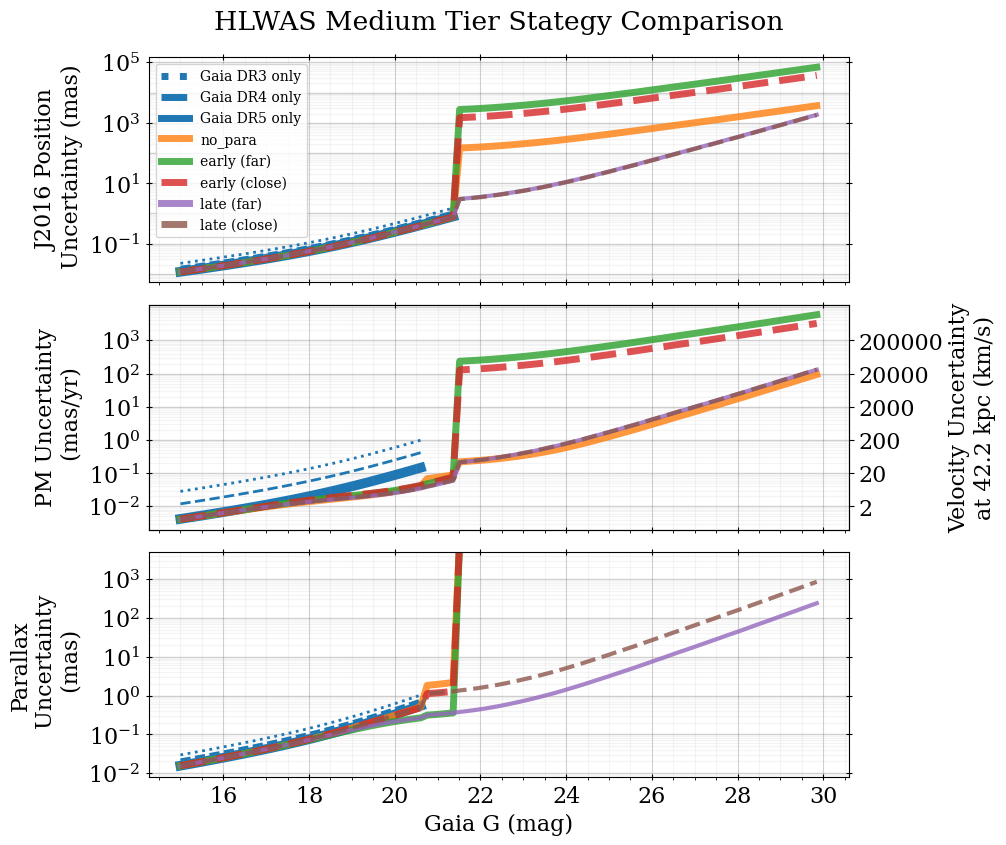

In [21]:


plt.figure(figsize=(10,9))
gs = gridspec.GridSpec(3,1,hspace=0.1,left=0.15,right=0.85,top=0.9,bottom=0.1)
ax = plt.subplot(gs[0])    

ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3, axis='x')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1, axis='x')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.title('HLWAS Medium Tier Stategy Comparison',pad=20)
dr = 'DR3'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_pos_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls=':')
dr = 'DR4'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_pos_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls='--')

plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_pos_errs,label=f'Gaia {precision_dict[key].gaia_era} only',
         zorder=-10,lw=7)
for ind,key in enumerate(precision_dict):
    if '(close)' in key:
        ls = '--'
    else:
        ls = '-'
    if 'late' in key:
        lw = 3
    else:
        lw = 5
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_pos_errs,label=key,ls=ls,lw=lw,alpha=0.8)
xlim = plt.xlim()
plt.ylabel('J2016 Position\n Uncertainty (mas)')
leg = plt.legend(loc=2,fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])

yticks = ax.get_yticks()
ylim = ax.get_ylim()
log_ticks = np.round(np.log10(ylim)+np.array([-1,1]))
major_lines = np.power(10,np.arange(log_ticks[0],log_ticks[1]+1))
minor_mults = np.arange(2,10,1)
for line in major_lines:
    plt.axhline(line,color='#666666',linestyle='-',alpha=0.3,zorder=-1e10,lw=1)
    for minor_mult in minor_mults:
        plt.axhline(line*minor_mult,color='#999999',linestyle='-',alpha=0.1,zorder=-1e10,lw=1)
ax.set_ylim(ylim)


ax = plt.subplot(gs[1])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3, axis='x')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1, axis='x')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
dr = 'DR3'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_pm_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls=':')
dr = 'DR4'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_pm_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls='--')
    
plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_pm_errs,label=f'Gaia {precision_dict[key].gaia_era} only',
         zorder=-10,lw=7)
for ind,key in enumerate(precision_dict):
    if '(close)' in key:
        ls = '--'
    else:
        ls = '-'
    if 'late' in key:
        lw = 3
    else:
        lw = 5
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_pm_errs,label=key,ls=ls,lw=lw,alpha=0.8)

ax.set_yticks(np.power(10.0,np.array([-2,-1,0,1,2,3])))
# plt.xlabel('Gaia G (mag)')
plt.xlim(xlim)
plt.ylabel('PM Uncertainty\n (mas/yr)')
ax.set_xticklabels([])

yticks = ax.get_yticks()
ylim = ax.get_ylim()
log_ticks = np.round(np.log10(ylim)+np.array([-1,1]))
major_lines = np.power(10,np.arange(log_ticks[0],log_ticks[1]+1))
minor_mults = np.arange(2,10,1)
for line in major_lines:
    plt.axhline(line,color='#666666',linestyle='-',alpha=0.3,zorder=-1e10,lw=1)
    for minor_mult in minor_mults:
        plt.axhline(line*minor_mult,color='#999999',linestyle='-',alpha=0.1,zorder=-1e10,lw=1)
ax.set_ylim(ylim)

#show velocity uncertainty at D kpc
D = 200/4.744
mult = 4.744*D
ylim = np.array(plt.ylim())
yticks = np.array(ax.get_yticks())
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_yticks(yticks*mult)
ax2.set_yticklabels(np.round(yticks*mult).astype(int))
ax2.set_ylim(ylim*mult)
ax2.set_ylabel('Velocity Uncertainty\nat %.1f kpc (km/s)'%D)



ax = plt.subplot(gs[2])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3, axis='x')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1, axis='x')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
dr = 'DR3'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_parallax_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls=':')
dr = 'DR4'
plt.plot(gaia_mags,gaia_precision_dict[dr]['gaia_parallax_errs'],label=f'Gaia {dr} only',
     zorder=10,lw=2,color='C0',ls='--')

plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_parallax_errs,label=f'Gaia {precision_dict[key].gaia_era} only',
         zorder=-10,lw=7)
for ind,key in enumerate(precision_dict):
    if '(close)' in key:
        ls = '--'
    else:
        ls = '-'
    if 'late' in key:
        lw = 3
    else:
        lw = 5
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_parallax_errs,label=key,ls=ls,lw=lw,alpha=0.8)
ylim = plt.ylim()
ax.set_yticks(np.power(10.0,np.array([-2,-1,0,1,2,3])))
plt.ylim(ylim[0],min(ylim[1],5e3))

yticks = ax.get_yticks()
ylim = ax.get_ylim()
log_ticks = np.round(np.log10(ylim)+np.array([-1,1]))
major_lines = np.power(10,np.arange(log_ticks[0],log_ticks[1]+1))
minor_mults = np.arange(2,10,1)
for line in major_lines:
    plt.axhline(line,color='#666666',linestyle='-',alpha=0.3,zorder=-1e10,lw=1)
    for minor_mult in minor_mults:
        plt.axhline(line*minor_mult,color='#999999',linestyle='-',alpha=0.1,zorder=-1e10,lw=1)
ax.set_ylim(ylim)

plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Uncertainty\n (mas)')
# plt.tight_layout()
plt.savefig(f'{plotpath}HLWAS_medium_astrometry.png')
plt.show()


In [16]:
wide_time_options = {
    # 'small_baseline':close_time + np.array([2,4.5])*u.year,
    'no_para':best_time + np.array([0,5.0])*u.year,
    'early (far)':best_time + np.array([0,0.5])*u.year,
    'early (close)':close_time + np.array([0,0.5])*u.year,
    'late (close)':close_time + np.array([0,4.5])*u.year,
    'late (far)':best_time + np.array([0,4.5])*u.year,
                   }

wide_filters = ['F158','F158']
wide_dithers = np.ones(len(wide_filters))*3
wide_MAs = ['IM_107_7']*len(wide_filters)


#example with 100 magnitudes
n_stars = 100

#assuming color of stars in all filters is 0 and zeropoint with Gaia is also 0
roman_filters = np.unique(wide_filters)
roman_mags = np.zeros((n_stars,len(roman_filters))) 
roman_mags[:] = np.linspace(16,27,n_stars)[:,None]         #AB mags
gaia_mags = roman_mags[:,0]

precision_dict = {}
for key in wide_time_options:
    wide_times = wide_time_options[key]
    
    wide_observation_list = list(zip(wide_times.mjd,wide_filters,wide_dithers,wide_MAs))
    precision_dict[key] = grc.gaia_roman_astrometric_precision(
        roman_mags = roman_mags,
        roman_filters = roman_filters,
        gaia_mags = gaia_mags,
        roman_pos_floor_err = roman_pos_floor_err,
        observation_list = wide_observation_list,
        gaia_era = gaia_era,
        ra = ra, dec = dec,
        roman_background = roman_background,
        roman_background_level = roman_background_level
    )
    

/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 2 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 2 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 2 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function

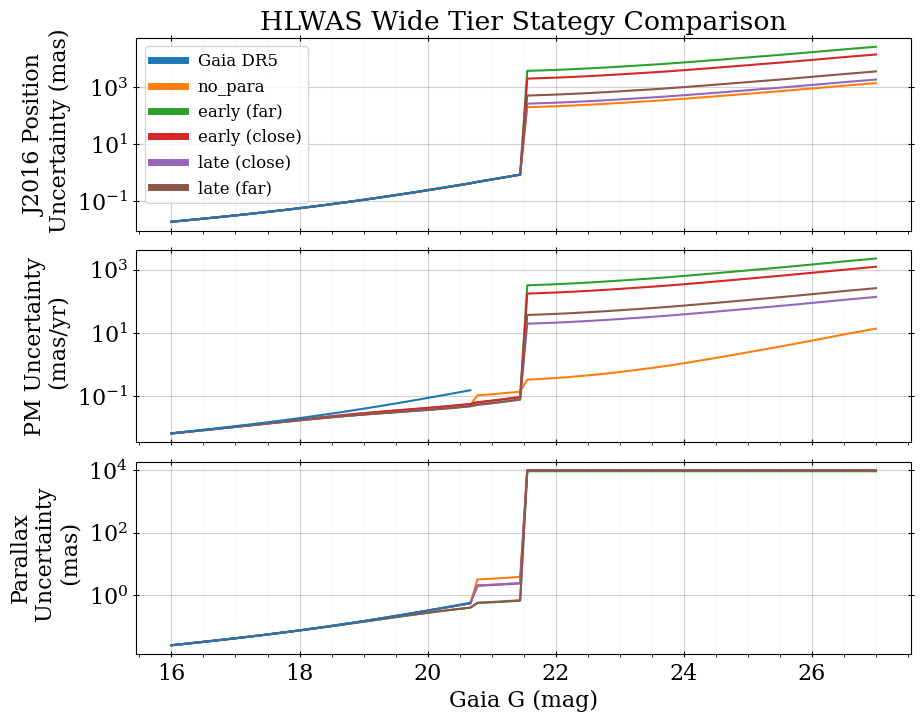

In [17]:


plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3,1,hspace=0.1)
ax = plt.subplot(gs[0])    

ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.title('HLWAS Wide Tier Stategy Comparison')
plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_pos_errs,label=f'Gaia {precision_dict[key].gaia_era}',zorder=10)
for ind,key in enumerate(precision_dict):
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_pos_errs,label=key)
xlim = plt.xlim()
plt.ylabel('J2016 Position\n Uncertainty (mas)')
leg = plt.legend(loc=2,fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])

ax = plt.subplot(gs[1])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_pm_errs,label=f'Gaia {precision_dict[key].gaia_era}',zorder=10)
for ind,key in enumerate(precision_dict):
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_pm_errs,label=key)
# plt.xlabel('Gaia G (mag)')
plt.xlim(xlim)
plt.ylabel('PM Uncertainty\n (mas/yr)')
ax.set_xticklabels([])

ax = plt.subplot(gs[2])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_parallax_errs,label=f'Gaia {precision_dict[key].gaia_era}',zorder=10)
for ind,key in enumerate(precision_dict):
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_parallax_errs,label=key)
plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Uncertainty\n (mas)')
# plt.tight_layout()
plt.show()


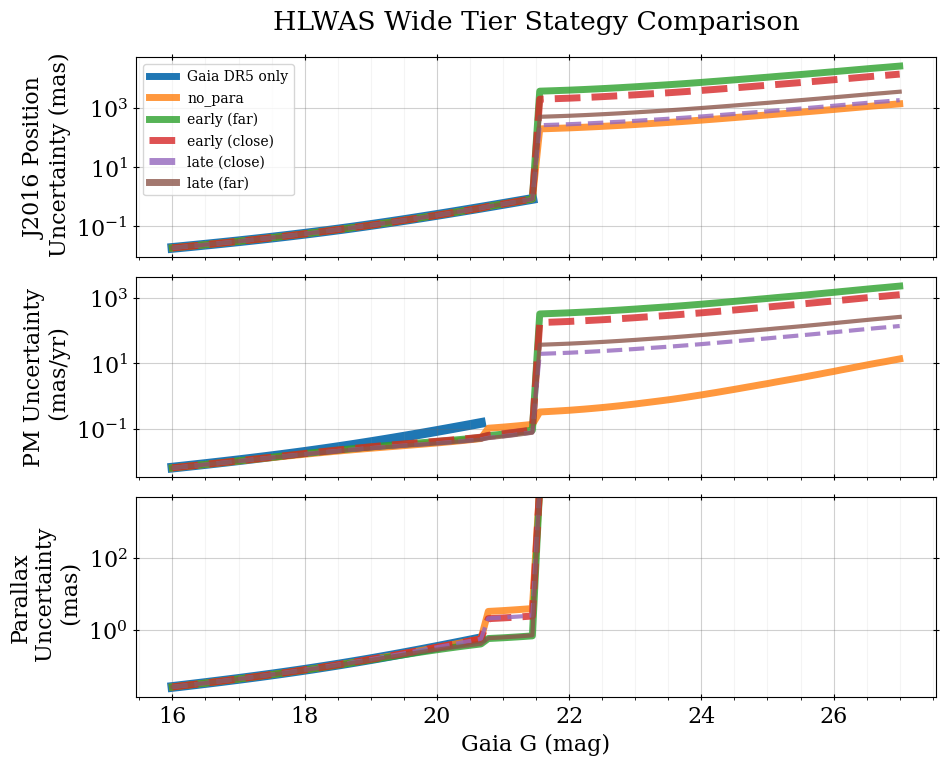

In [18]:


plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3,1,hspace=0.1,left=0.15,right=0.95,top=0.9,bottom=0.1)
ax = plt.subplot(gs[0])    

ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.title('HLWAS Wide Tier Stategy Comparison',pad=20)

plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_pos_errs,label=f'Gaia {precision_dict[key].gaia_era} only',
         zorder=-10,lw=7)
for ind,key in enumerate(precision_dict):
    if '(close)' in key:
        ls = '--'
    else:
        ls = '-'
    if 'late' in key:
        lw = 3
    else:
        lw = 5
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_pos_errs,label=key,ls=ls,lw=lw,alpha=0.8)
xlim = plt.xlim()
plt.ylabel('J2016 Position\n Uncertainty (mas)')
leg = plt.legend(loc=2,fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])

ax = plt.subplot(gs[1])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
    
plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_pm_errs,label=f'Gaia {precision_dict[key].gaia_era} only',
         zorder=-10,lw=7)
for ind,key in enumerate(precision_dict):
    if '(close)' in key:
        ls = '--'
    else:
        ls = '-'
    if 'late' in key:
        lw = 3
    else:
        lw = 5
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_pm_errs,label=key,ls=ls,lw=lw,alpha=0.8)

# plt.xlabel('Gaia G (mag)')
plt.xlim(xlim)
plt.ylabel('PM Uncertainty\n (mas/yr)')
ax.set_xticklabels([])

ax = plt.subplot(gs[2])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

plt.plot(precision_dict[key].gaia_gs,precision_dict[key].gaia_parallax_errs,label=f'Gaia {precision_dict[key].gaia_era} only',
         zorder=-10,lw=7)
for ind,key in enumerate(precision_dict):
    if '(close)' in key:
        ls = '--'
    else:
        ls = '-'
    if 'late' in key:
        lw = 3
    else:
        lw = 5
    plt.plot(precision_dict[key].gaia_gs,precision_dict[key].final_parallax_errs,label=key,ls=ls,lw=lw,alpha=0.8)
ylim = plt.ylim()
plt.ylim(ylim[0],min(ylim[1],5e3))
plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Uncertainty\n (mas)')
# plt.tight_layout()
# plt.savefig(f'{plotpath}HLWAS_medium_astrometry.png')
plt.show()
